In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

import librosa.display
import random
import torch
import pydot
import graphviz
from scipy.signal import wiener

# this is used for Contant Q Transform
from nnAudio.Spectrogram import CQT1992v2
from tensorflow.keras.applications import EfficientNetB0 as efn

2024-06-08 18:40:40.168424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-08 18:40:40.168450: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_label_dataset = pd.read_csv('/home/ubuntu/gwd_data/training_labels.csv', nrows=50000)
train_label_dataset

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
49995,16bbd5495a,0
49996,16bbd682aa,0
49997,16bbf24906,0
49998,16bc152384,0


In [3]:
train_label_dataset.shape

(50000, 2)

<Axes: xlabel='target', ylabel='count'>

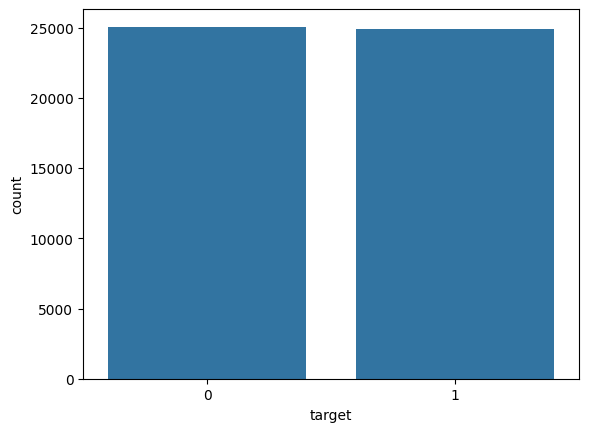

In [4]:
sns.countplot(data=train_label_dataset, x="target")

In [5]:
train_label_dataset['target'].value_counts()

target
0    25065
1    24935
Name: count, dtype: int64

In [6]:
train_label_dataset.isnull().sum() # no null

id        0
target    0
dtype: int64

In [7]:
train_path = glob('/home/ubuntu/gwd_data/train/*/*/*/*')

In [8]:
len(train_path)

560000

In [9]:
explore_sample_3 = np.load(train_path[3])
explore_sample_3

array([[ 4.44067032e-21,  3.96114073e-21,  3.84968257e-21, ...,
         2.72702585e-21,  2.97027211e-21,  2.75764005e-21],
       [-9.57126854e-21, -9.08588049e-21, -9.19045706e-21, ...,
        -5.25659879e-21, -5.52017922e-21, -5.46639575e-21],
       [-2.28059951e-21, -1.86006949e-21, -2.39821478e-21, ...,
        -2.73254294e-21, -2.39238654e-21, -2.49321621e-21]])

In [10]:
explore_sample_3.shape

(3, 4096)

In [11]:
print(len(explore_sample_3[0]), len(explore_sample_3[1]), len(explore_sample_3[2]))

4096 4096 4096


In [12]:
# just a tensor representation
tf.convert_to_tensor(explore_sample_3[0])

2024-06-08 18:40:44.525005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-08 18:40:44.525030: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-08 18:40:44.525045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-Default-string): /proc/driver/nvidia/version does not exist
2024-06-08 18:40:44.525285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(4096,), dtype=float64, numpy=
array([4.44067032e-21, 3.96114073e-21, 3.84968257e-21, ...,
       2.72702585e-21, 2.97027211e-21, 2.75764005e-21])>

In [13]:
train_path[3]

'/home/ubuntu/gwd_data/train/8/8/8/888e7ac55f.npy'

In [14]:
rind = train_path[3].rindex('/') # last index where the character '/' appeared
extracted_id_for_explore_sample_3 = train_path[3][rind+1:].replace('.npy', '') # replaced .npy
extracted_id_for_explore_sample_3

'888e7ac55f'

In [15]:
train_label_dataset[train_label_dataset['id']==extracted_id_for_explore_sample_3]['target']

Series([], Name: target, dtype: int64)

In [16]:
positive_sample = explore_sample_3
# index 1 od train_path has a target of 0 so it is a negative sample.
negative_sample = np.load(train_path[1])
negative_sample

array([[ 4.28428980e-21,  4.13817616e-21,  3.96321934e-21, ...,
         3.50927372e-21,  3.27030939e-21,  3.24735452e-21],
       [ 4.26027220e-21,  4.15096723e-21,  4.31037957e-21, ...,
         1.04494520e-20,  1.04948097e-20,  1.08558365e-20],
       [ 8.93111755e-22,  6.66970955e-22,  7.04609241e-22, ...,
        -6.49845811e-22, -1.10836775e-21, -5.17153344e-22]])

In [17]:
samples = (positive_sample, negative_sample)
targets = (1, 0)

0it [00:00, ?it/s]

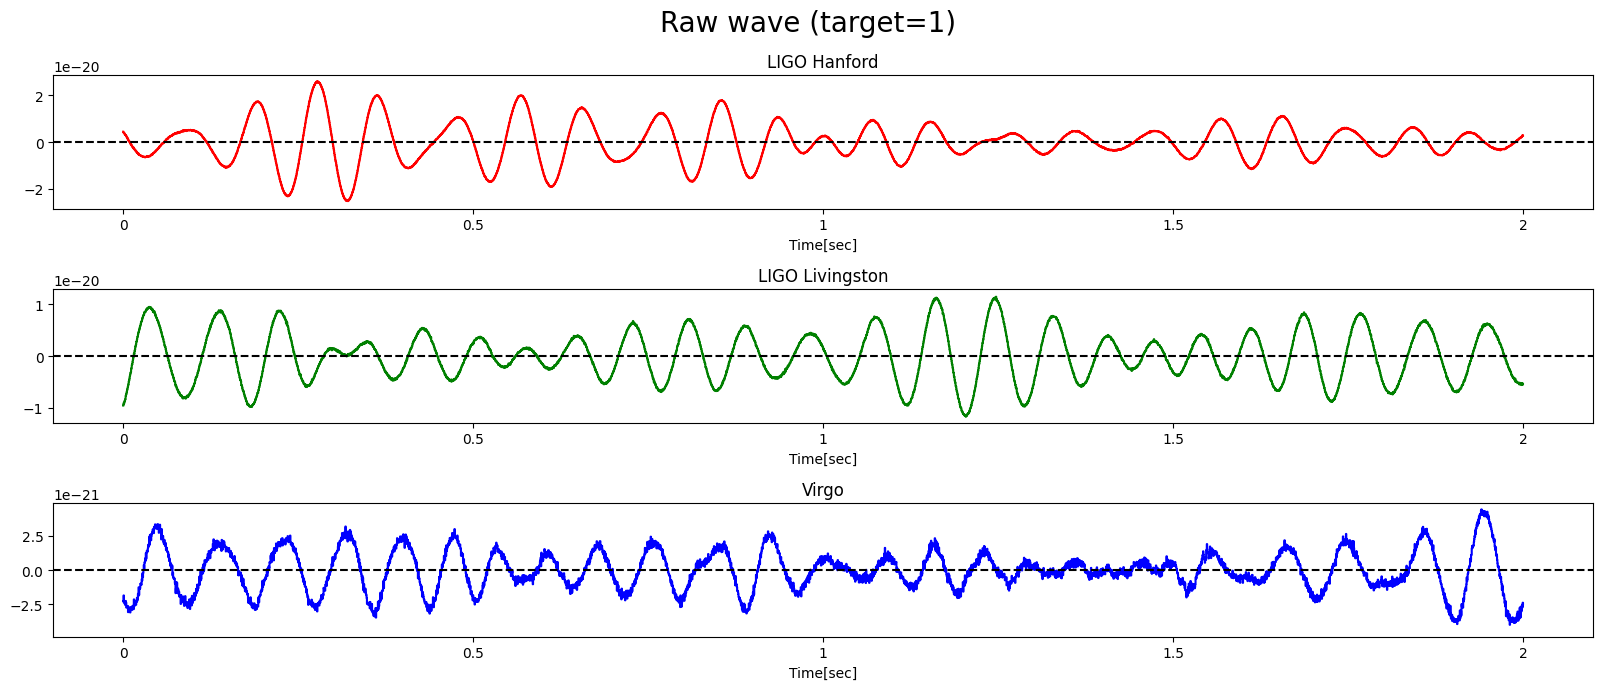

1it [00:01,  1.73s/it]

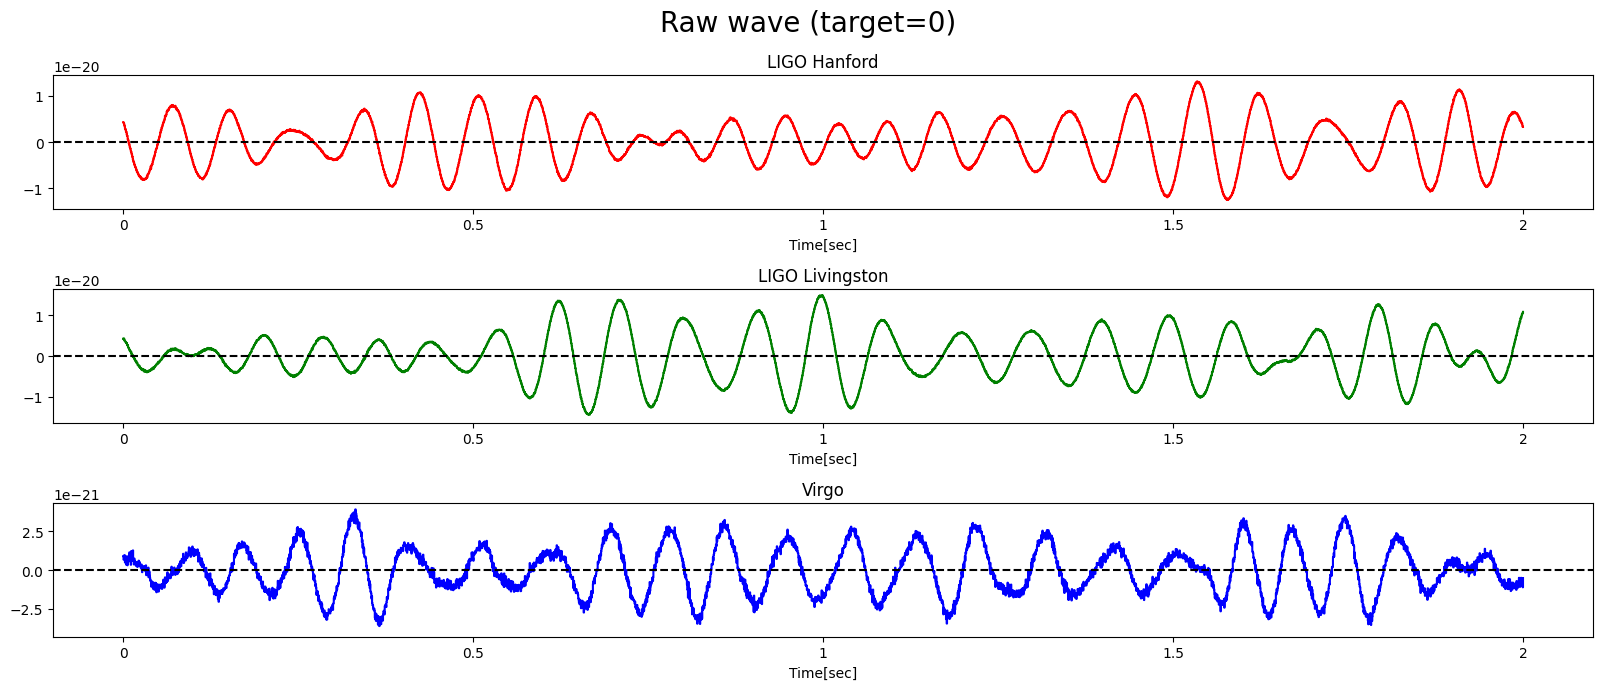

2it [00:02,  1.34s/it]


In [18]:
colors = ("red", "green", "blue")
signal_names = ("LIGO Hanford", "LIGO Livingston", "Virgo")

for x, i in tqdm(zip(samples, targets)):
    figure = plt.figure(figsize=(16, 7))
    figure.suptitle(f'Raw wave (target={i})', fontsize=20)
    # range is 3 because we have 3 different rows for each interferometer
    for j in range(3):
        axes = figure.add_subplot(3, 1, j + 1)
        librosa.display.waveshow(x[j], sr=2048, ax=axes, color=colors[j])
        axes.axhline(y=0, color='black', linestyle='--')  # Add horizontal line at y=0
        axes.set_title(signal_names[j], fontsize=12)
        axes.set_xlabel('Time[sec]')
    plt.tight_layout()
    plt.show()

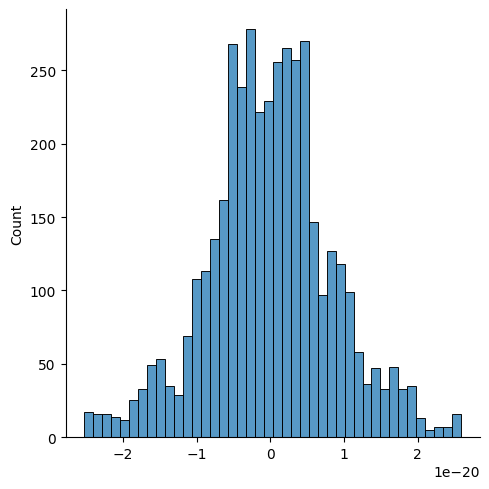

In [19]:
sns.displot(positive_sample[0,:])

In [20]:
pd.set_option('display.max_colwidth',None)

In [21]:
ids = []
for files in train_path:
    ids.append(files[files.rindex('/')+1:].replace('.npy',''))
df = pd.DataFrame({"id":ids,"path":train_path})
df = pd.merge(df, train_label_dataset, on='id')

In [22]:
df.head()

,id,path,target
0,128ddce033,/home/ubuntu/gwd_data/train/1/2/8/128ddce033.npy,1
1,128fc49ffd,/home/ubuntu/gwd_data/train/1/2/8/128fc49ffd.npy,0
2,1285cb2e21,/home/ubuntu/gwd_data/train/1/2/8/1285cb2e21.npy,0
3,128c3cb9ff,/home/ubuntu/gwd_data/train/1/2/8/128c3cb9ff.npy,1
4,12804fe88a,/home/ubuntu/gwd_data/train/1/2/8/12804fe88a.npy,1


In [23]:
df.shape

(50000, 3)

In [24]:
# CQT
transform = CQT1992v2(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=500,      # max freq
                hop_length=64,  # hop length
                verbose=False)

In [25]:
# the Cqt function
# preprocess function
def preprocess_function_cqt_spec(path,i):
    signal = np.load(path.numpy())[i]
    # tensor conversion
    signal = torch.from_numpy(signal).float()
    # getting the image from CQT transform
    image = transform(signal)
    # converting to array from tensor
    image = np.array(image)
    # transpose the image to get right orientation
    image = np.transpose(image,(1,2,0))
    # Resize the image to the desired shape
    image = tf.image.resize(image, (56, 193))
    
    # conver the image to tf.tensor and return
    return tf.convert_to_tensor(image)

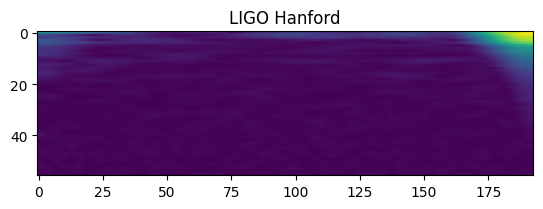

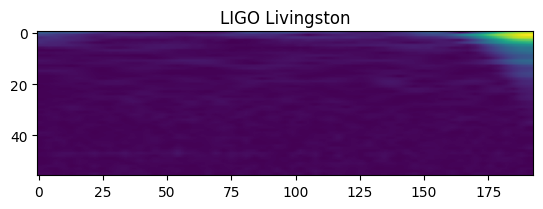

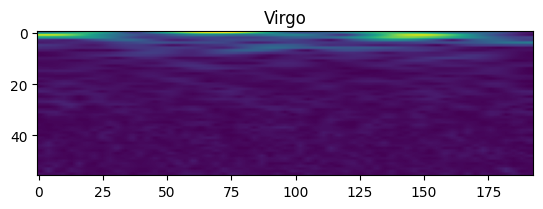

In [26]:
signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
for i in range(3):
    image = preprocess_function_cqt_spec(tf.convert_to_tensor(df['path'][2]), i)
    plt.imshow(image)
    plt.title(signal_names[i])
    plt.show()

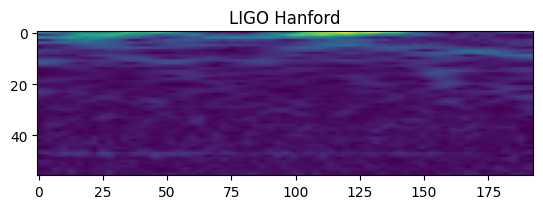

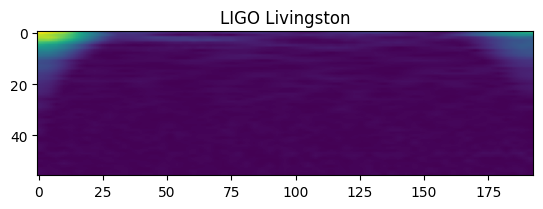

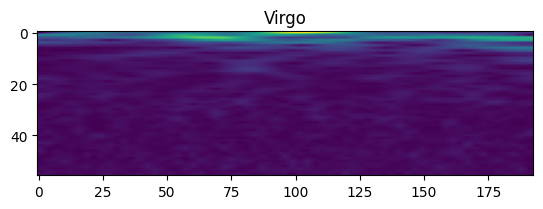

In [27]:
signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
for i in range(3):
    image = preprocess_function_cqt_spec(tf.convert_to_tensor(df['path'][0]), i)
    plt.imshow(image)
    plt.title(signal_names[i])
    plt.show()

# Before Adding Noise

In [28]:
# the Cqt function
# preprocess function
def preprocess_function_cqt(path):
    signal = np.load(path.numpy())
    # there are 3 signal as explained before for each interferometers
    for i in range(signal.shape[0]):
        # normalize signal
        signal[i] /= np.max(signal[i])
    # horizontal stack
    signal = np.hstack(signal)
    # tensor conversion
    signal = torch.from_numpy(signal).float()
    # getting the image from CQT transform
    image = transform(signal)
    # converting to array from tensor
    image = np.array(image)
    # transpose the image to get right orientation
    image = np.transpose(image,(1,2,0))
    # Resize the image to the desired shape
    image = tf.image.resize(image, (28, 96))
    
    # conver the image to tf.tensor and return
    return tf.convert_to_tensor(image)

(28, 96, 1)


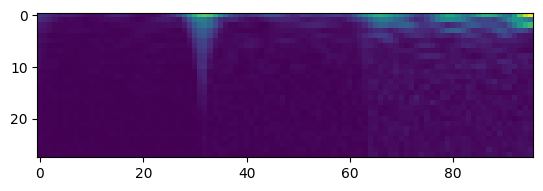

In [29]:
image = preprocess_function_cqt(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

(28, 96, 1)


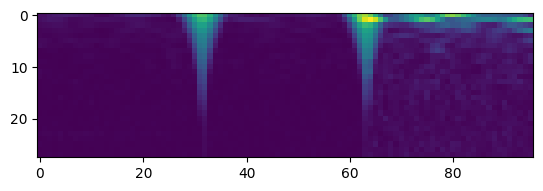

In [30]:
image = preprocess_function_cqt(tf.convert_to_tensor(df['path'][0]))
print(image.shape)
plt.imshow(image)

In [31]:
input_shape = (28, 96, 1)
batch_size = 64

In [32]:
X = df['id']
y = df['target'].astype('int8').values

In [33]:
y

array([1, 0, 0, ..., 1, 0, 1], dtype=int8)

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state = 42,test_size=0.05, stratify = y)

In [35]:
def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'/home/ubuntu/gwd_data/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [36]:
def preprocess_function_parse_tf(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset = valid_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
def preprocess_function_cqt_from_array(signal_array):
    for i in range(signal_array.shape[0]):
        signal_array[i] /= np.max(signal_array[i])
    signal_array = np.hstack(signal_array)
    signal_tensor = torch.from_numpy(signal_array).float()
    image = transform(signal_tensor)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))
    image = tf.image.resize(image, (28, 96))
    return tf.convert_to_tensor(image)

def generate_thermal_noise(signal, snr_db):
    # Compute the power of the signal
    signal_power = np.mean(signal ** 2)
    # Compute the noise power to achieve the desired SNR
    noise_power = signal_power / (10 ** (snr_db / 10))
    # Generate thermal noise with Rayleigh distribution
    noise = np.random.rayleigh(scale=np.sqrt(noise_power), size=signal.shape)
    return noise

def add_noise_to_signal(signal, noise):
    return signal + noise

def compute_snr(signal, noisy_signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((noisy_signal - signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def remove_noise_wiener(noisy_signal, noise):
    # Apply Wiener filter to each channel separately
    clean_signal = np.array([wiener(noisy_signal[i], noise=None) for i in range(noisy_signal.shape[0])])
    return clean_signal

def remove_noise_bayesian_inference(noisy_signal, noise):
    # Estimate clean signal by subtracting the mean of the noise
    clean_signal = noisy_signal - np.mean(noise)
    return clean_signal

# Adding Thermal Noise

In [39]:
def preprocess_function_cqt_th(path):
    # Example usage
    signal = np.load(path.numpy())  # Load your gravitational wave signal
    
    # Generate 40 dB thermal noise
    thermal_noise = generate_thermal_noise(signal, 30)
    
    # Add thermal noise to the signal
    noisy_signal = add_noise_to_signal(signal, thermal_noise)
    
    # Compute SNR after adding noise
    snr_with_noise = compute_snr(signal, noisy_signal)
    #print(f'SNR after adding noise: {snr_with_noise} dB')

    # Visualize the noisy signal
    image = preprocess_function_cqt_from_array(noisy_signal)

    return(image)

(28, 96, 1)


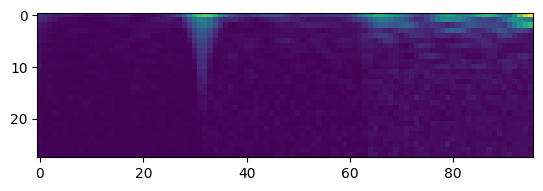

In [40]:
image = preprocess_function_cqt_th(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

(28, 96, 1)


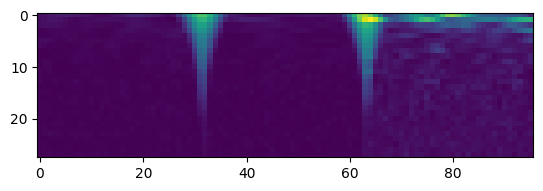

In [41]:
image = preprocess_function_cqt_th(tf.convert_to_tensor(df['path'][0]))
print(image.shape)
plt.imshow(image)

In [42]:
def preprocess_function_parse_tf_th(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt_th, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

In [43]:
train_dataset_th = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset_th = train_dataset_th.shuffle(len(x_train))
train_dataset_th = train_dataset_th.map(preprocess_function_parse_tf_th, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_th = train_dataset_th.batch(batch_size)
train_dataset_th = train_dataset_th.prefetch(tf.data.AUTOTUNE)

valid_dataset_th = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset_th = valid_dataset_th.map(preprocess_function_parse_tf_th, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_th = valid_dataset_th.batch(batch_size)
valid_dataset_th = valid_dataset_th.prefetch(tf.data.AUTOTUNE)

# Removing Noise Using Wiener Filter

In [44]:
def preprocess_function_cqt_thwf(path):
    # Example usage
    signal = np.load(path.numpy())  # Load your gravitational wave signal
    
    # Generate 40 dB thermal noise
    thermal_noise = generate_thermal_noise(signal, 30)
    
    # Add thermal noise to the signal
    noisy_signal = add_noise_to_signal(signal, thermal_noise)
    
    # Compute SNR after adding noise
    snr_with_noise = compute_snr(signal, noisy_signal)
    #print(f'SNR after adding noise: {snr_with_noise} dB')

    # Remove noise using Wiener filtering
    cleaned_signal = remove_noise_wiener(noisy_signal, thermal_noise)
    
    # Compute SNR after noise removal
    snr_after_removal = compute_snr(signal, cleaned_signal)
    #print(f'SNR after noise removal: {snr_after_removal} dB')
    
    # Visualize the noisy signal
    image = preprocess_function_cqt_from_array(cleaned_signal)
    
    return(image)

(28, 96, 1)


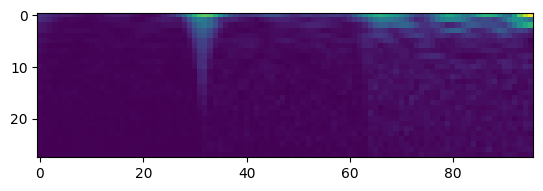

In [45]:
image = preprocess_function_cqt_thwf(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

(28, 96, 1)


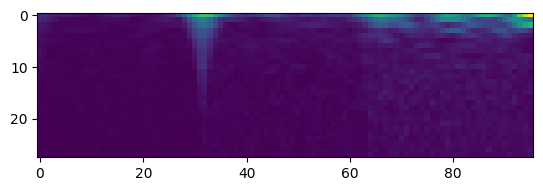

In [46]:
image = preprocess_function_cqt_thwf(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

In [47]:
def preprocess_function_parse_tf_thwf(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt_thwf, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

In [48]:
train_dataset_thwf = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset_thwf = train_dataset_thwf.shuffle(len(x_train))
train_dataset_thwf = train_dataset_thwf.map(preprocess_function_parse_tf_thwf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_thwf = train_dataset_thwf.batch(batch_size)
train_dataset_thwf = train_dataset_thwf.prefetch(tf.data.AUTOTUNE)

valid_dataset_thwf = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset_thwf = valid_dataset_thwf.map(preprocess_function_parse_tf_thwf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_thwf = valid_dataset_thwf.batch(batch_size)
valid_dataset_thwf = valid_dataset_thwf.prefetch(tf.data.AUTOTUNE)

# Removing Noise Using Bayesian Inference

In [49]:
def preprocess_function_cqt_thbi(path):
    # Example usage
    signal = np.load(path.numpy())  # Load your gravitational wave signal
    
    # Generate 40 dB thermal noise
    thermal_noise = generate_thermal_noise(signal, 30)
    
    # Add thermal noise to the signal
    noisy_signal = add_noise_to_signal(signal, thermal_noise)
    
    # Compute SNR after adding noise
    snr_with_noise = compute_snr(signal, noisy_signal)
    #print(f'SNR after adding noise: {snr_with_noise} dB')

    # Remove noise using Wiener filtering
    cleaned_signal = remove_noise_bayesian_inference(noisy_signal, thermal_noise)
    
    # Compute SNR after noise removal
    snr_after_removal = compute_snr(signal, cleaned_signal)
    #print(f'SNR after noise removal: {snr_after_removal} dB')
    
    # Visualize the noisy signal
    image = preprocess_function_cqt_from_array(cleaned_signal)
    
    return(image)

(28, 96, 1)


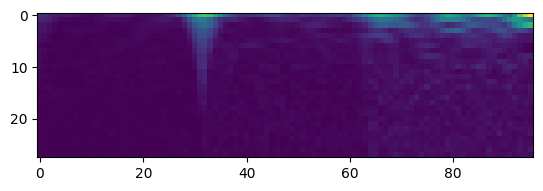

In [50]:
image = preprocess_function_cqt_thbi(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

(28, 96, 1)


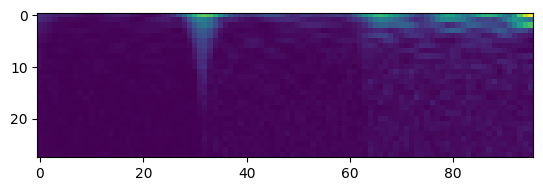

In [51]:
image = preprocess_function_cqt_thbi(tf.convert_to_tensor(df['path'][1]))
print(image.shape)
plt.imshow(image)

In [52]:
def preprocess_function_parse_tf_thbi(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt_thwf, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

In [53]:
train_dataset_thbi = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset_thbi = train_dataset_thbi.shuffle(len(x_train))
train_dataset_thbi = train_dataset_thbi.map(preprocess_function_parse_tf_thbi, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_thbi = train_dataset_thbi.batch(batch_size)
train_dataset_thbi = train_dataset_thbi.prefetch(tf.data.AUTOTUNE)

valid_dataset_thbi = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset_thbi = valid_dataset_thbi.map(preprocess_function_parse_tf_thbi, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset_thbi = valid_dataset_thbi.batch(batch_size)
valid_dataset_thbi = valid_dataset_thbi.prefetch(tf.data.AUTOTUNE)

# CNN

In [74]:
# Instantiate the Sequential model
model_cnn = Sequential(name='CNN_model')
model_cnn.add(Conv2D(3, 3, input_shape=input_shape, activation='relu', padding='same'))
#model_cnn.add(EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'))
model_cnn.add(Flatten())
model_cnn.add(Dense(32,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


model_cnn_th=model_cnn
model_cnn_thwf=model_cnn
model_cnn_thbi=model_cnn

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 96, 3)         30        
                                                                 
 flatten_2 (Flatten)         (None, 8064)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                258080    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 258,143
Trainable params: 258,143
Non-trainable params: 0
_________________________________________________________________


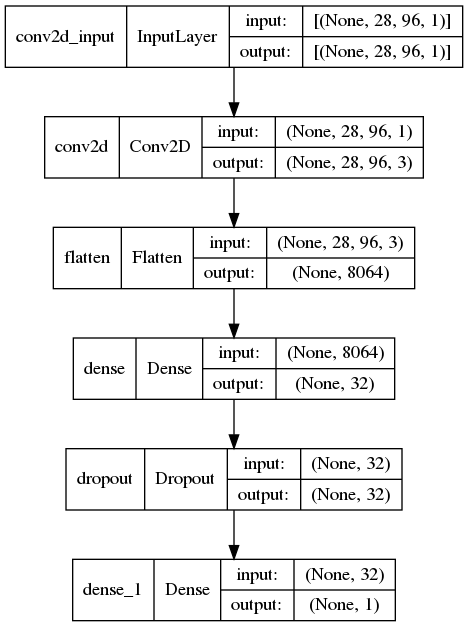

In [55]:
plot_model(model_cnn, show_shapes=True)

# CNN - Before Adding Noise

In [56]:
# Fit the data
history_cnn = model_cnn.fit(x=train_dataset,
                            epochs=10,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 122s 164ms/step - loss: 0.6715 - accuracy: 0.5644 - val_loss: 0.6148 - val_accuracy: 0.6924
Epoch 2/10
743/743 [==============================] - 123s 166ms/step - loss: 0.6051 - accuracy: 0.6560 - val_loss: 0.5806 - val_accuracy: 0.7192
Epoch 3/10
743/743 [==============================] - 122s 164ms/step - loss: 0.5957 - accuracy: 0.6670 - val_loss: 0.5510 - val_accuracy: 0.7208
Epoch 4/10
743/743 [==============================] - 122s 164ms/step - loss: 0.5890 - accuracy: 0.6708 - val_loss: 0.5779 - val_accuracy: 0.6840
Epoch 5/10
743/743 [==============================] - 122s 164ms/step - loss: 0.5807 - accuracy: 0.6789 - val_loss: 0.5598 - val_accuracy: 0.7044
Epoch 6/10
743/743 [==============================] - 122s 165ms/step - loss: 0.5765 - accuracy: 0.6848 - val_loss: 0.5366 - val_accuracy: 0.7312
Epoch 7/10
743/743 [==============================] - 122s 164ms/step - loss: 0.5652 - accuracy: 0.6961 - val_loss: 0.5267 -

In [57]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(valid_dataset)
print("Test Accuracy:", test_acc_cnn) 

40/40 [==============================] - 6s 146ms/step - loss: 0.5064 - accuracy: 0.7480
Test Accuracy: 0.7480000257492065


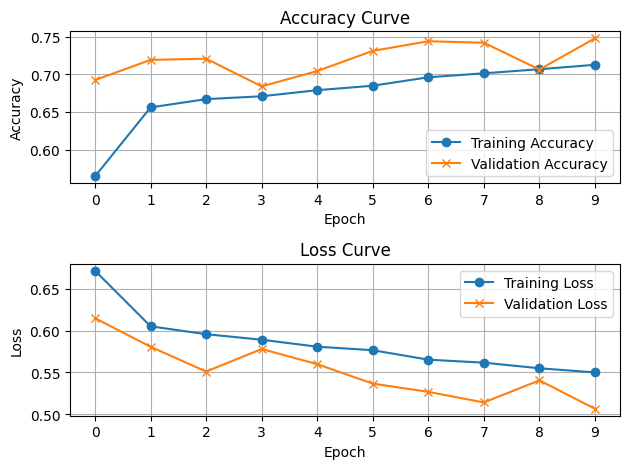

In [58]:
# Define empty lists to store accuracy and loss values
train_loss_cnn = []
train_accuracy_cnn = []
val_loss_cnn = []
val_accuracy_cnn = []

# Extract accuracy and loss values from the history object
train_loss_cnn = history_cnn.history['loss']
train_accuracy_cnn = history_cnn.history['accuracy']
val_loss_cnn = history_cnn.history['val_loss']
val_accuracy_cnn = history_cnn.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_cnn, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_cnn, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_cnn, marker='o', label='Training Loss')
axs[1].plot(val_loss_cnn, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [59]:
preds_cnn=model_cnn.predict(valid_dataset)
preds_cnn

array([[0.32734376],
       [0.59775454],
       [0.32734376],
       ...,
       [0.32734376],
       [0.3633201 ],
       [0.33536565]], dtype=float32)

In [60]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_cnn = (preds_cnn >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_cnn = np.concatenate([i.numpy() for _, i in valid_dataset], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_cnn = confusion_matrix(true_labels_cnn, binary_predictions_cnn)

print("Confusion Matrix:")
print(conf_matrix_cnn)

Confusion Matrix:
[[1091  162]
 [ 468  779]]


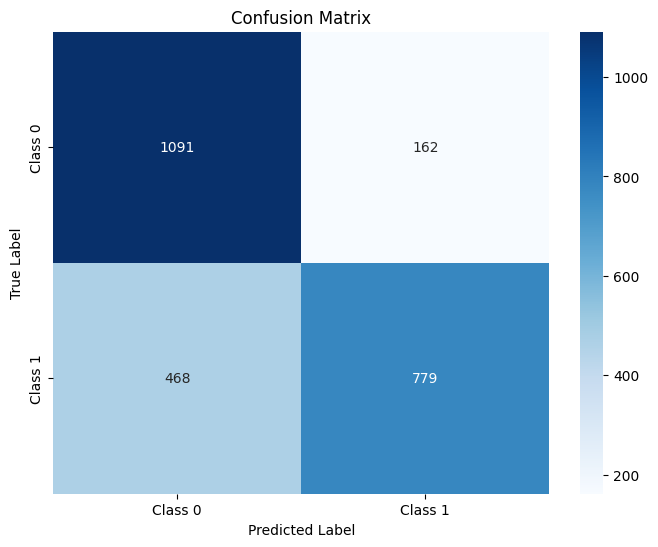

In [61]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

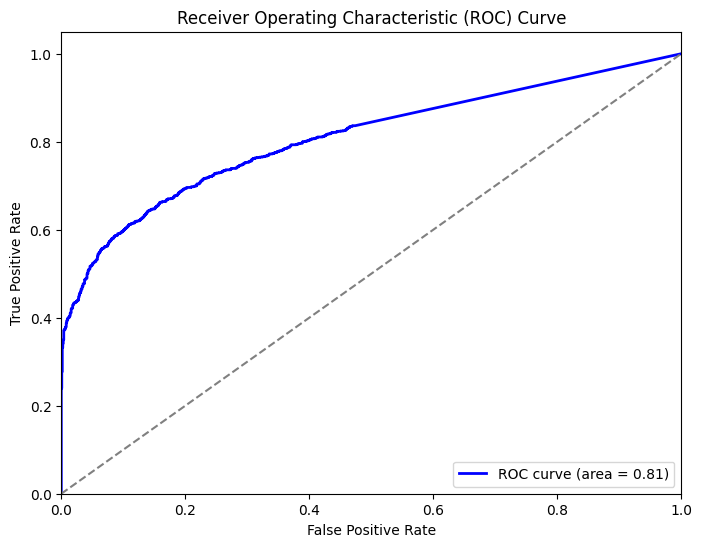

In [62]:
probas_cnn = preds_cnn.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(true_labels_cnn, probas_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# CNN - Thermal Noise 

In [65]:
# Fit the data
history_cnn_th = model_cnn_th.fit(x=train_dataset_th,
                            epochs=10,
                            validation_data=valid_dataset_th,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 143s 192ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5044
Epoch 2/10
743/743 [==============================] - 140s 188ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5072
Epoch 3/10
743/743 [==============================] - 141s 189ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 4/10
743/743 [==============================] - 143s 192ms/step - loss: 0.6927 - accuracy: 0.5059 - val_loss: 0.6874 - val_accuracy: 0.5296
Epoch 5/10
743/743 [==============================] - 143s 192ms/step - loss: 0.6544 - accuracy: 0.5952 - val_loss: 0.6336 - val_accuracy: 0.6080
Epoch 6/10
743/743 [==============================] - 143s 192ms/step - loss: 0.6184 - accuracy: 0.6455 - val_loss: 0.5995 - val_accuracy: 0.6528
Epoch 7/10
743/743 [==============================] - 143s 193ms/step - loss: 0.6012 - accuracy: 0.6622 - val_loss: 0.6023 -

In [66]:
test_loss_cnn_th, test_acc_cnn_th = model_cnn_th.evaluate(valid_dataset_th)
print("Test Accuracy:", test_acc_cnn_th) 

40/40 [==============================] - 7s 171ms/step - loss: 0.5750 - accuracy: 0.6836
Test Accuracy: 0.6836000084877014


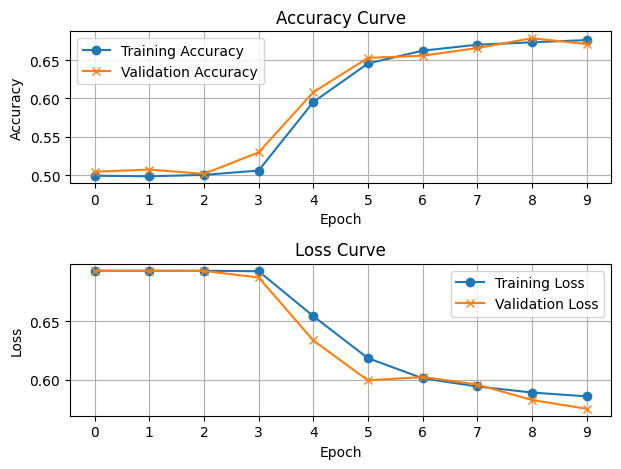

In [136]:
# Define empty lists to store accuracy and loss values
train_loss_cnn_th = []
train_accuracy_cnn_th = []
val_loss_cnn_th = []
val_accuracy_cnn_th = []

# Extract accuracy and loss values from the history object
train_loss_cnn_th = history_cnn_th.history['loss']
train_accuracy_cnn_th = history_cnn_th.history['accuracy']
val_loss_cnn_th = history_cnn_th.history['val_loss']
val_accuracy_cnn_th = history_cnn_th.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_cnn_th, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_cnn_th, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_cnn_th, marker='o', label='Training Loss')
axs[1].plot(val_loss_cnn_th, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [68]:
preds_cnn_th=model_cnn_th.predict(valid_dataset_th)
preds_cnn_th

array([[0.30262643],
       [0.51552993],
       [0.32803375],
       ...,
       [0.40369803],
       [0.32895505],
       [0.322784  ]], dtype=float32)

In [69]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_cnn_th = (preds_cnn_th >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_cnn_th = np.concatenate([i.numpy() for _, i in valid_dataset_th], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_cnn_th = confusion_matrix(true_labels_cnn_th, binary_predictions_cnn_th)

print("Confusion Matrix:")
print(conf_matrix_cnn_th)

Confusion Matrix:
[[987 266]
 [526 721]]


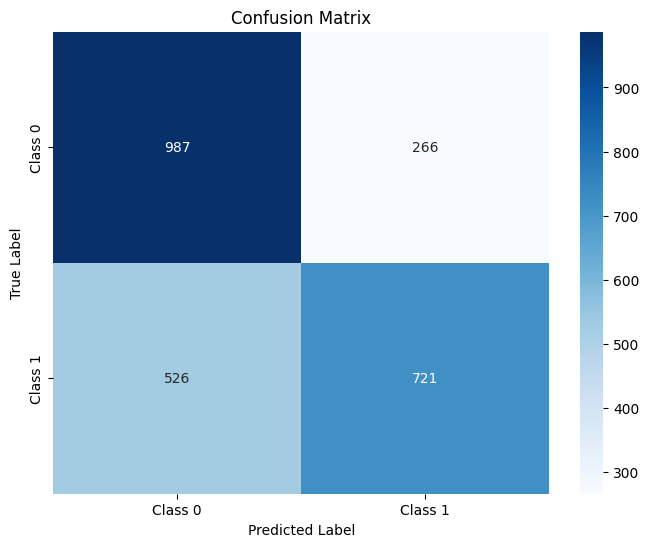

In [70]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_th, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

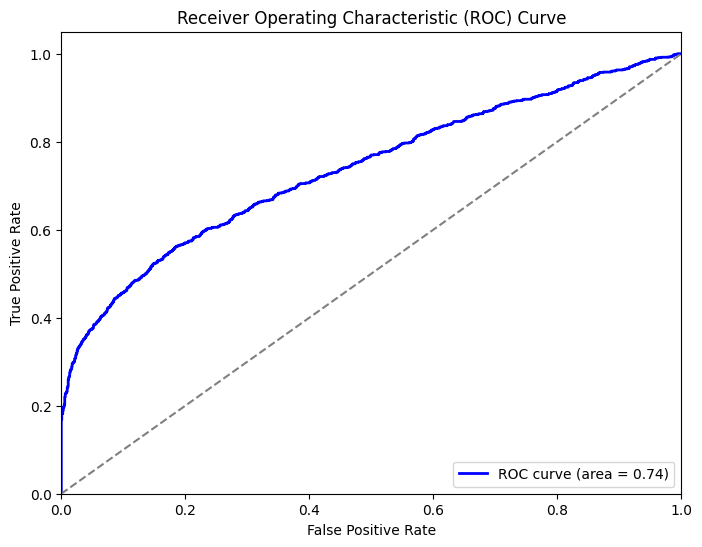

In [71]:
probas_cnn_th = preds_cnn_th.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_cnn_th, tpr_cnn_th, thresholds_cnn_th = roc_curve(true_labels_cnn_th, probas_cnn_th)
roc_auc_cnn_th = auc(fpr_cnn_th, tpr_cnn_th)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn_th, tpr_cnn_th, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn_th)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparison Before and After Adding Noise

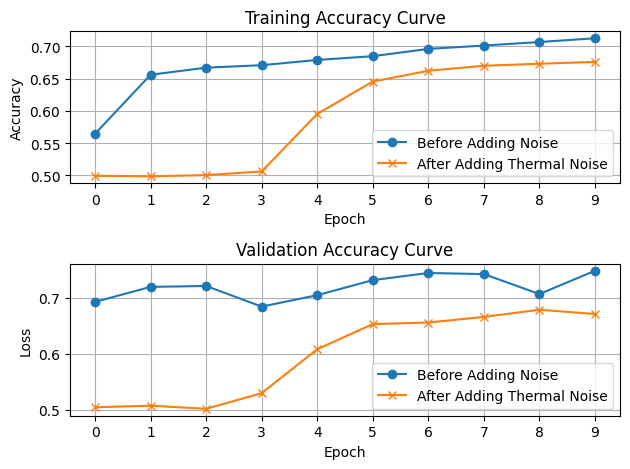

In [72]:
# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_cnn, marker='o', label='Before Adding Noise')
axs[0].plot(train_accuracy_cnn_th, marker='x', label='After Adding Thermal Noise')
axs[0].set_title('Training Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(val_accuracy_cnn, marker='o', label='Before Adding Noise')
axs[1].plot(val_accuracy_cnn_th, marker='x', label='After Adding Thermal Noise')
axs[1].set_title('Validation Accuracy Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

# CNN - Wiener Filter

In [75]:
# Fit the data
history_cnn_thwf = model_cnn_thwf.fit(x=train_dataset_thwf,
                            epochs=10,
                            validation_data=valid_dataset_thwf,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 248s 333ms/step - loss: 0.6868 - accuracy: 0.5344 - val_loss: 0.6605 - val_accuracy: 0.5520
Epoch 2/10
743/743 [==============================] - 254s 342ms/step - loss: 0.6601 - accuracy: 0.5811 - val_loss: 0.6277 - val_accuracy: 0.6544
Epoch 3/10
743/743 [==============================] - 255s 343ms/step - loss: 0.6393 - accuracy: 0.6109 - val_loss: 0.5925 - val_accuracy: 0.6860
Epoch 4/10
743/743 [==============================] - 254s 342ms/step - loss: 0.6305 - accuracy: 0.6243 - val_loss: 0.5890 - val_accuracy: 0.6896
Epoch 5/10
743/743 [==============================] - 256s 344ms/step - loss: 0.6275 - accuracy: 0.6255 - val_loss: 0.6051 - val_accuracy: 0.6676
Epoch 6/10
743/743 [==============================] - 255s 343ms/step - loss: 0.6227 - accuracy: 0.6327 - val_loss: 0.6152 - val_accuracy: 0.6572
Epoch 7/10
743/743 [==============================] - 255s 343ms/step - loss: 0.6248 - accuracy: 0.6258 - val_loss: 0.5778 -

In [76]:
test_loss_cnn_thwf, test_acc_cnn_thwf = model_cnn_thwf.evaluate(valid_dataset_thwf)
print("Test Accuracy:", test_acc_cnn_thwf) 

40/40 [==============================] - 13s 315ms/step - loss: 0.6224 - accuracy: 0.6344
Test Accuracy: 0.6344000101089478


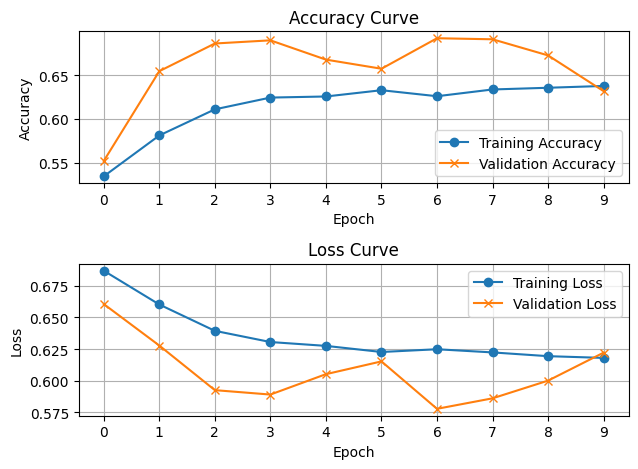

In [77]:
# Define empty lists to store accuracy and loss values
train_loss_cnn_thwf = []
train_accuracy_cnn_thwf = []
val_loss_cnn_thwf = []
val_accuracy_cnn_thwf = []

# Extract accuracy and loss values from the history object
train_loss_cnn_thwf = history_cnn_thwf.history['loss']
train_accuracy_cnn_thwf = history_cnn_thwf.history['accuracy']
val_loss_cnn_thwf = history_cnn_thwf.history['val_loss']
val_accuracy_cnn_thwf = history_cnn_thwf.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_cnn_thwf, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_cnn_thwf, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_cnn_thwf, marker='o', label='Training Loss')
axs[1].plot(val_loss_cnn_thwf, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [78]:
preds_cnn_thwf=model_cnn_thwf.predict(valid_dataset_thwf)
preds_cnn_thwf

array([[0.4034897],
       [0.4034897],
       [0.4034897],
       ...,
       [0.4034897],
       [0.4034897],
       [0.4034897]], dtype=float32)

In [79]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_cnn_thwf = (preds_cnn_thwf >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_cnn_thwf = np.concatenate([i.numpy() for _, i in valid_dataset_thwf], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_cnn_thwf = confusion_matrix(true_labels_cnn_thwf, binary_predictions_cnn_thwf)

print("Confusion Matrix:")
print(conf_matrix_cnn_thwf)

Confusion Matrix:
[[1236   17]
 [ 893  354]]


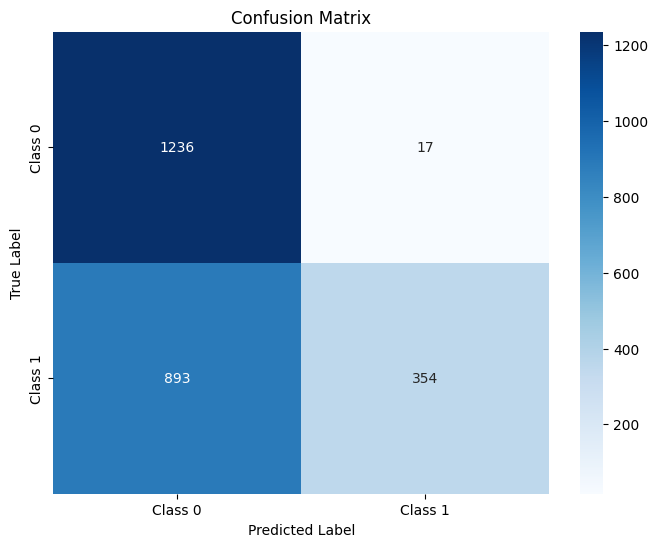

In [80]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_thwf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

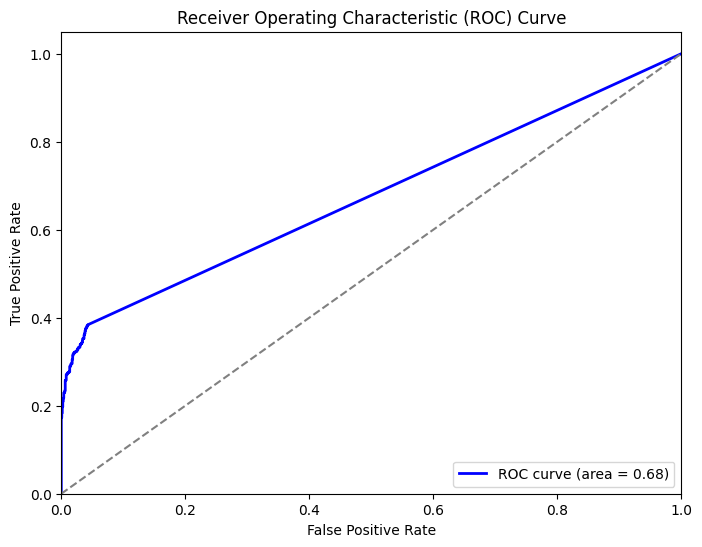

In [81]:
probas_cnn_thwf = preds_cnn_thwf.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_cnn_thwf, tpr_cnn_thwf, thresholds_cnn_thwf = roc_curve(true_labels_cnn_thwf, probas_cnn_thwf)
roc_auc_cnn_thwf = auc(fpr_cnn_thwf, tpr_cnn_thwf)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn_thwf, tpr_cnn_thwf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn_thwf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# CNN - Bayesian Inference

In [82]:
# Fit the data
history_cnn_thbi = model_cnn_thbi.fit(x=train_dataset_thbi,
                            epochs=10,
                            validation_data=valid_dataset_thbi,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 249s 335ms/step - loss: 0.6206 - accuracy: 0.6327 - val_loss: 0.5824 - val_accuracy: 0.6880
Epoch 2/10
743/743 [==============================] - 244s 328ms/step - loss: 0.6186 - accuracy: 0.6366 - val_loss: 0.5801 - val_accuracy: 0.6912
Epoch 3/10
743/743 [==============================] - 230s 309ms/step - loss: 0.6152 - accuracy: 0.6393 - val_loss: 0.5749 - val_accuracy: 0.6960
Epoch 4/10
743/743 [==============================] - 229s 308ms/step - loss: 0.6149 - accuracy: 0.6419 - val_loss: 0.5800 - val_accuracy: 0.6960
Epoch 5/10
743/743 [==============================] - 251s 338ms/step - loss: 0.6156 - accuracy: 0.6401 - val_loss: 0.5885 - val_accuracy: 0.6976
Epoch 6/10
743/743 [==============================] - 253s 341ms/step - loss: 0.6153 - accuracy: 0.6400 - val_loss: 0.5985 - val_accuracy: 0.6648
Epoch 7/10
743/743 [==============================] - 253s 340ms/step - loss: 0.6113 - accuracy: 0.6439 - val_loss: 0.5817 -

In [83]:
test_loss_cnn_thbi, test_acc_cnn_thbi = model_cnn_thbi.evaluate(valid_dataset_thbi)
print("Test Accuracy:", test_acc_cnn_thbi) 

40/40 [==============================] - 12s 302ms/step - loss: 0.5667 - accuracy: 0.7048
Test Accuracy: 0.704800009727478


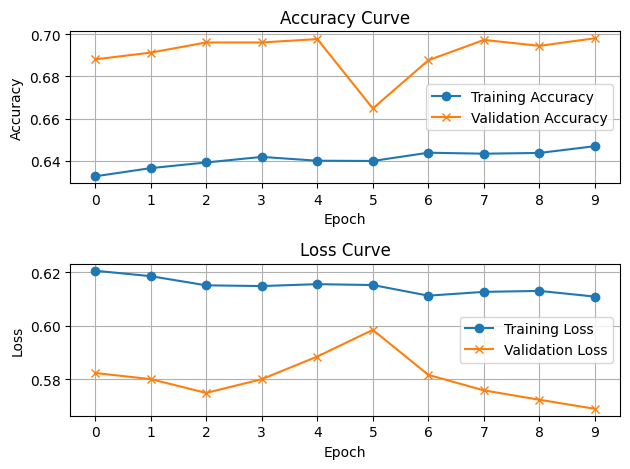

In [84]:
# Define empty lists to store accuracy and loss values
train_loss_cnn_thbi = []
train_accuracy_cnn_thbi = []
val_loss_cnn_thbi = []
val_accuracy_cnn_thbi = []

# Extract accuracy and loss values from the history object
train_loss_cnn_thbi = history_cnn_thbi.history['loss']
train_accuracy_cnn_thbi = history_cnn_thbi.history['accuracy']
val_loss_cnn_thbi = history_cnn_thbi.history['val_loss']
val_accuracy_cnn_thbi = history_cnn_thbi.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_cnn_thbi, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_cnn_thbi, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_cnn_thbi, marker='o', label='Training Loss')
axs[1].plot(val_loss_cnn_thbi, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [85]:
preds_cnn_thbi=model_cnn_thbi.predict(valid_dataset_thbi)
preds_cnn_thbi

array([[0.3953618],
       [0.3953618],
       [0.3953618],
       ...,
       [0.3953618],
       [0.3953618],
       [0.6989157]], dtype=float32)

In [86]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_cnn_thbi = (preds_cnn_thbi >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_cnn_thbi = np.concatenate([i.numpy() for _, i in valid_dataset_thbi], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_cnn_thbi = confusion_matrix(true_labels_cnn_thbi, binary_predictions_cnn_thbi)

print("Confusion Matrix:")
print(conf_matrix_cnn_thbi)

Confusion Matrix:
[[997 256]
 [511 736]]


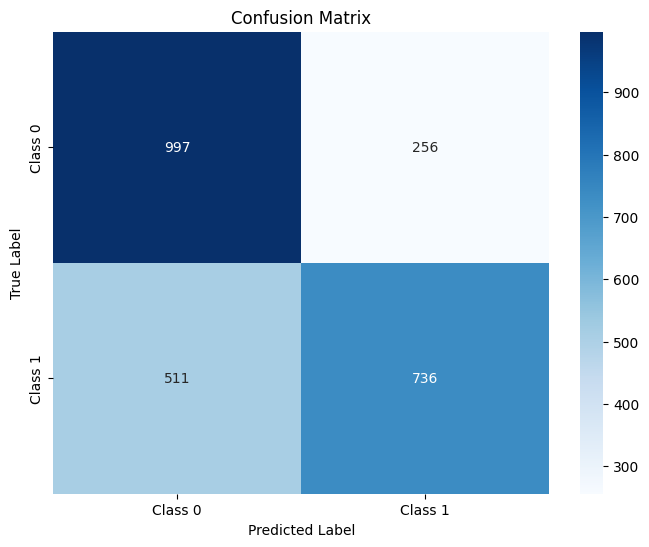

In [87]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_thbi, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

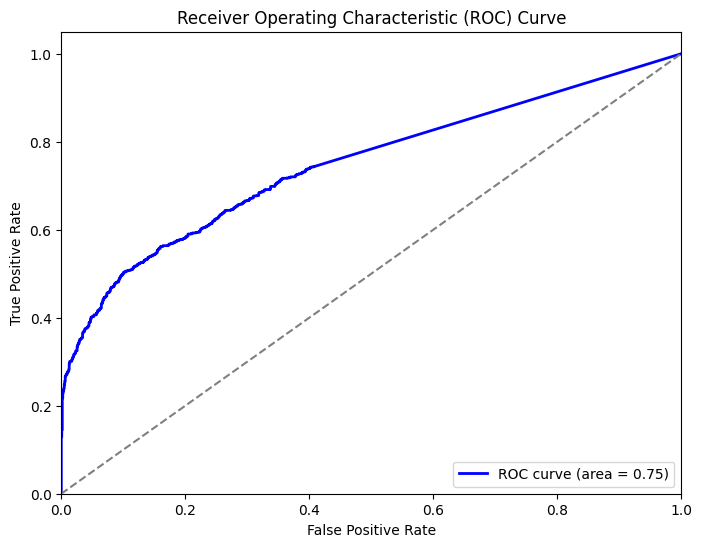

In [88]:
probas_cnn_thbi = preds_cnn_thbi.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_cnn_thbi, tpr_cnn_thbi, thresholds_cnn_thbi = roc_curve(true_labels_cnn_thbi, probas_cnn_thbi)
roc_auc_cnn_thbi = auc(fpr_cnn_thbi, tpr_cnn_thbi)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn_thbi, tpr_cnn_thbi, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn_thbi)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Final CNN Graph

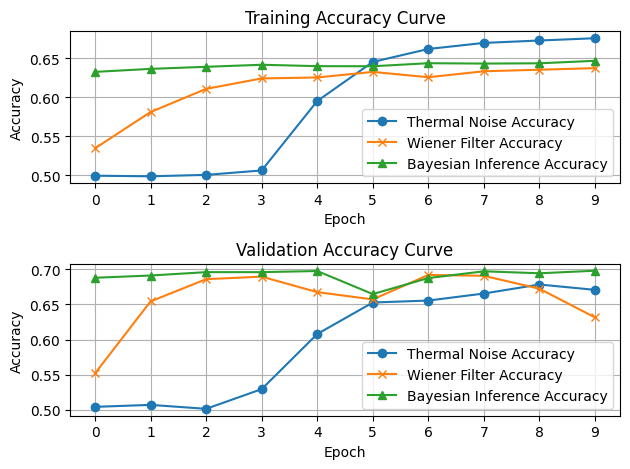

In [89]:
# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the training accuracy
axs[0].plot(train_accuracy_cnn_th, marker='o', label='Thermal Noise Accuracy')
axs[0].plot(train_accuracy_cnn_thwf, marker='x', label='Wiener Filter Accuracy')
axs[0].plot(train_accuracy_cnn_thbi, marker='^', label='Bayesian Inference Accuracy')
axs[0].set_title('Training Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the validation accuracy
axs[1].plot(val_accuracy_cnn_th, marker='o', label='Thermal Noise Accuracy')
axs[1].plot(val_accuracy_cnn_thwf, marker='x', label='Wiener Filter Accuracy')
axs[1].plot(val_accuracy_cnn_thbi, marker='^', label='Bayesian Inference Accuracy')
axs[1].set_title('Validation Accuracy Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

# QCNN

In [98]:
import tensorflow as tf
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from cirq.contrib.svg import SVGCircuit

In [99]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        # filter size: 2^n only for this version!
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[2]
        self.height = input_shape[1]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, j, i, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y] 
            
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_y, self.num_x, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)

In [100]:
# Example usage:
qcnn_model = tf.keras.Sequential()
qcnn_model.add(QConv(filter_size=2, depth=3, activation='relu', input_shape=input_shape))
qcnn_model.add(tf.keras.layers.Flatten())
qcnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
qcnn_model.add(Dropout(0.5))
qcnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# Compile the model
qcnn_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
# Print the model summary
qcnn_model.summary()

qcnn_model_th=qcnn_model
qcnn_model_thwf=qcnn_model
qcnn_model_thbi=qcnn_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv_2 (QConv)            (None, 27, 95, 3)         18        
                                                                 
 flatten_4 (Flatten)         (None, 7695)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                246272    
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 246,323
Trainable params: 246,323
Non-trainable params: 0
_________________________________________________________________


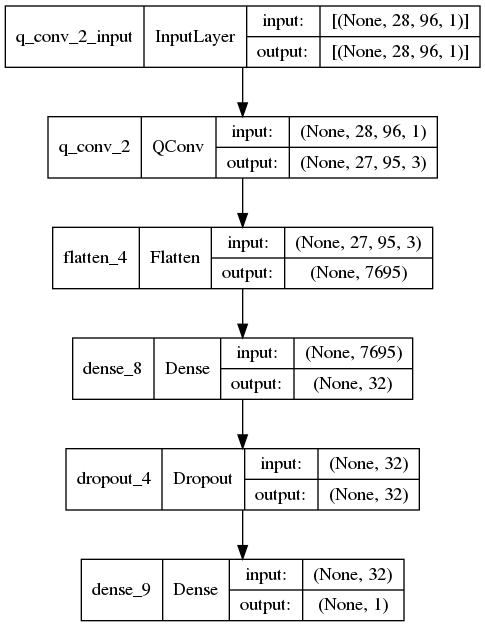

In [101]:
plot_model(qcnn_model, show_shapes=True)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


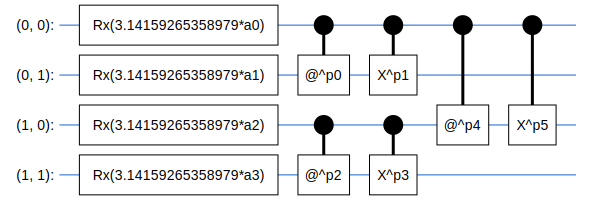

In [102]:
SVGCircuit(QConv(filter_size=2, depth=3, activation='relu').circuit)

# QCNN - Before Adding Noise  

In [103]:
history_qcnn =  qcnn_model.fit(x=train_dataset,
                epochs=10,  
                validation_data=valid_dataset,
                batch_size=batch_size,
                verbose=1)

Epoch 1/10
743/743 [==============================] - 17935s 24s/step - loss: 0.6822 - accuracy: 0.5443 - val_loss: 0.6520 - val_accuracy: 0.6644
Epoch 2/10
743/743 [==============================] - 17891s 24s/step - loss: 0.6418 - accuracy: 0.6192 - val_loss: 0.6193 - val_accuracy: 0.6768
Epoch 3/10
743/743 [==============================] - 18073s 24s/step - loss: 0.6166 - accuracy: 0.6490 - val_loss: 0.5902 - val_accuracy: 0.6964
Epoch 4/10
743/743 [==============================] - 17919s 24s/step - loss: 0.6021 - accuracy: 0.6587 - val_loss: 0.5565 - val_accuracy: 0.7260
Epoch 5/10
743/743 [==============================] - 17862s 24s/step - loss: 0.5929 - accuracy: 0.6717 - val_loss: 0.5519 - val_accuracy: 0.7264
Epoch 6/10
743/743 [==============================] - 17903s 24s/step - loss: 0.5808 - accuracy: 0.6842 - val_loss: 0.5474 - val_accuracy: 0.7220
Epoch 7/10
743/743 [==============================] - 17892s 24s/step - loss: 0.5777 - accuracy: 0.6851 - val_loss: 0.5471 -

In [104]:
test_loss_qcnn, test_acc_qcnn = qcnn_model.evaluate(valid_dataset)
print("Test Accuracy:", test_acc_qcnn)

40/40 [==============================] - 515s 13s/step - loss: 0.5318 - accuracy: 0.7296
Test Accuracy: 0.7296000123023987


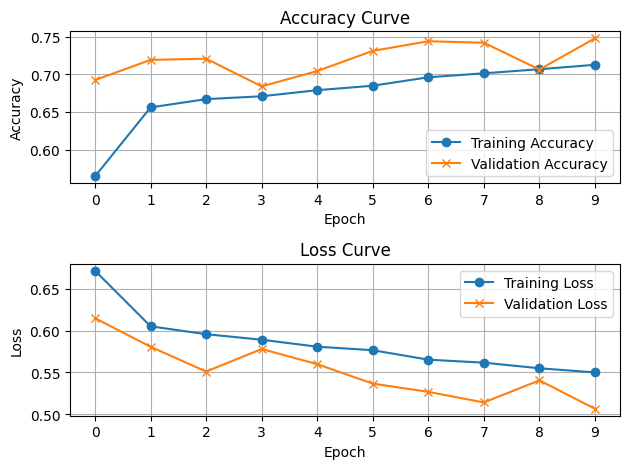

In [105]:
# Define empty lists to store accuracy and loss values
train_loss_qcnn = []
train_accuracy_qcnn = []
val_loss_qcnn = []
val_accuracy_qcnn = []

# Extract accuracy and loss values from the history object
train_loss_qcnn = history_cnn.history['loss']
train_accuracy_qcnn = history_cnn.history['accuracy']
val_loss_qcnn = history_cnn.history['val_loss']
val_accuracy_qcnn = history_cnn.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_qcnn, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_qcnn, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_qcnn, marker='o', label='Training Loss')
axs[1].plot(val_loss_qcnn, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [106]:
preds_qcnn=qcnn_model.predict(valid_dataset)
preds_qcnn

array([[0.35394627],
       [0.4546865 ],
       [0.35394627],
       ...,
       [0.3801494 ],
       [0.35394627],
       [0.35394627]], dtype=float32)

In [107]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_qcnn = (preds_qcnn >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_qcnn = np.concatenate([i.numpy() for _, i in valid_dataset], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_qcnn = confusion_matrix(true_labels_qcnn, binary_predictions_qcnn)

print("Confusion Matrix:")
print(conf_matrix_qcnn)

Confusion Matrix:
[[1147  106]
 [ 570  677]]


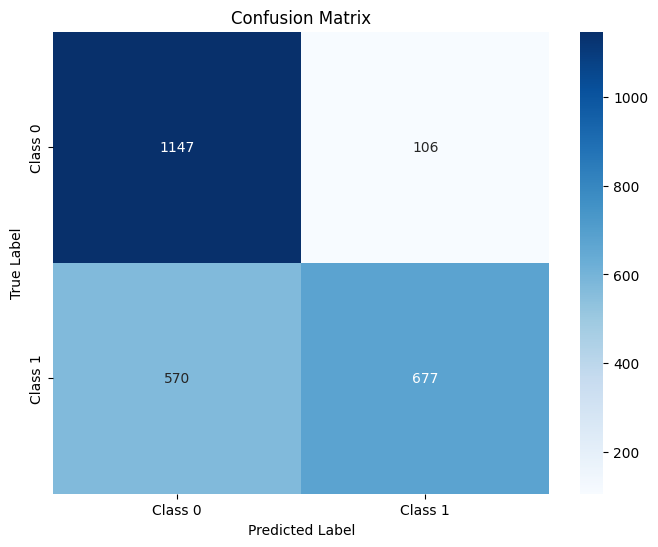

In [108]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qcnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

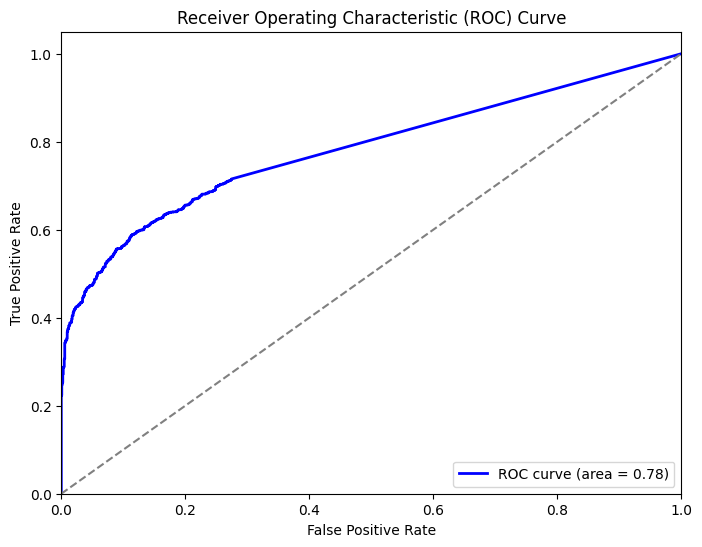

In [109]:
probas_qcnn = preds_qcnn.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_qcnn, tpr_qcnn, thresholds_qcnn = roc_curve(true_labels_qcnn, probas_qcnn)
roc_auc_qcnn = auc(fpr_qcnn, tpr_qcnn)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_qcnn, tpr_qcnn, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_qcnn)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# QCNN - Thermal Noise 

In [110]:
# Fit the data
history_qcnn_th = qcnn_model_th.fit(x=train_dataset_th,
                            epochs=10,
                            validation_data=valid_dataset_th,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 18023s 24s/step - loss: 0.6092 - accuracy: 0.6519 - val_loss: 0.5705 - val_accuracy: 0.6988
Epoch 2/10
743/743 [==============================] - 18026s 24s/step - loss: 0.6044 - accuracy: 0.6559 - val_loss: 0.5694 - val_accuracy: 0.7032
Epoch 3/10
743/743 [==============================] - 17918s 24s/step - loss: 0.6122 - accuracy: 0.6486 - val_loss: 0.5958 - val_accuracy: 0.6876
Epoch 4/10
743/743 [==============================] - 17894s 24s/step - loss: 0.6049 - accuracy: 0.6581 - val_loss: 0.5731 - val_accuracy: 0.6876
Epoch 5/10
743/743 [==============================] - 18128s 24s/step - loss: 0.6058 - accuracy: 0.6555 - val_loss: 0.5752 - val_accuracy: 0.6892
Epoch 6/10
743/743 [==============================] - 17936s 24s/step - loss: 0.6010 - accuracy: 0.6579 - val_loss: 0.5742 - val_accuracy: 0.6896
Epoch 7/10
743/743 [==============================] - 17926s 24s/step - loss: 0.6010 - accuracy: 0.6605 - val_loss: 0.5696 -

In [111]:
test_loss_qcnn_th, test_acc_qcnn_th = qcnn_model_th.evaluate(valid_dataset_th)
print("Test Accuracy:", test_acc_qcnn_th) 

40/40 [==============================] - 494s 12s/step - loss: 0.5763 - accuracy: 0.6900
Test Accuracy: 0.6899999976158142


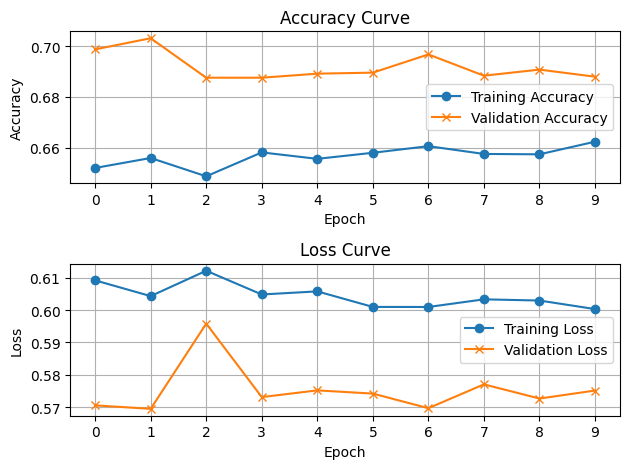

In [135]:
# Define empty lists to store accuracy and loss values
train_loss_qcnn_th = []
train_accuracy_qcnn_th = []
val_loss_qcnn_th = []
val_accuracy_qcnn_th = []

# Extract accuracy and loss values from the history object
train_loss_qcnn_th = history_qcnn_th.history['loss']
train_accuracy_qcnn_th = history_qcnn_th.history['accuracy']
val_loss_qcnn_th = history_qcnn_th.history['val_loss']
val_accuracy_qcnn_th = history_qcnn_th.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_qcnn_th, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_qcnn_th, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_qcnn_th, marker='o', label='Training Loss')
axs[1].plot(val_loss_qcnn_th, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [113]:
preds_qcnn_th=qcnn_model_th.predict(valid_dataset_th)
preds_qcnn_th

array([[0.37820736],
       [0.37820736],
       [0.37820736],
       ...,
       [0.37820736],
       [0.37820736],
       [0.37820736]], dtype=float32)

In [114]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_qcnn_th = (preds_qcnn_th >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_qcnn_th = np.concatenate([i.numpy() for _, i in valid_dataset_th], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_qcnn_th = confusion_matrix(true_labels_qcnn_th, binary_predictions_qcnn_th)

print("Confusion Matrix:")
print(conf_matrix_qcnn_th)

Confusion Matrix:
[[1054  199]
 [ 600  647]]


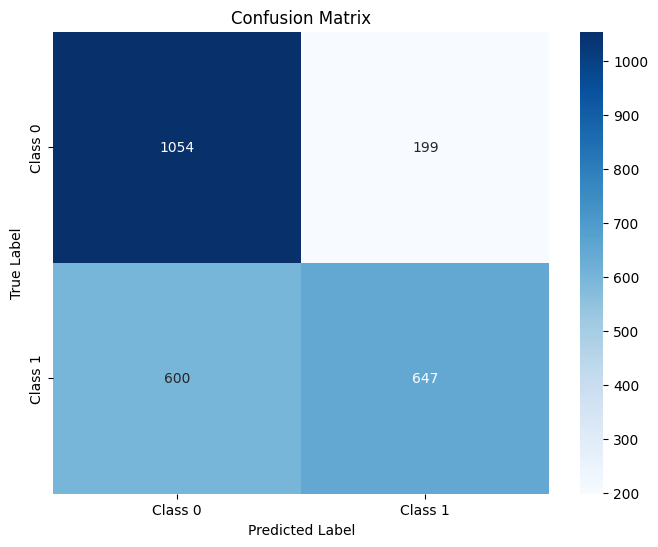

In [115]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qcnn_th, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

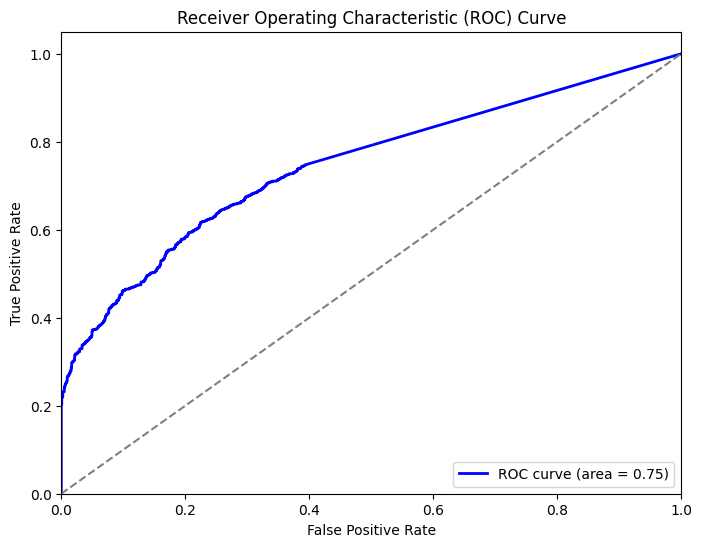

In [116]:
probas_qcnn_th = preds_qcnn_th.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_qcnn_th, tpr_qcnn_th, thresholds_qcnn_th = roc_curve(true_labels_qcnn_th, probas_qcnn_th)
roc_auc_qcnn_th = auc(fpr_qcnn_th, tpr_qcnn_th)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_qcnn_th, tpr_qcnn_th, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_qcnn_th)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparison Before and After Adding Noise

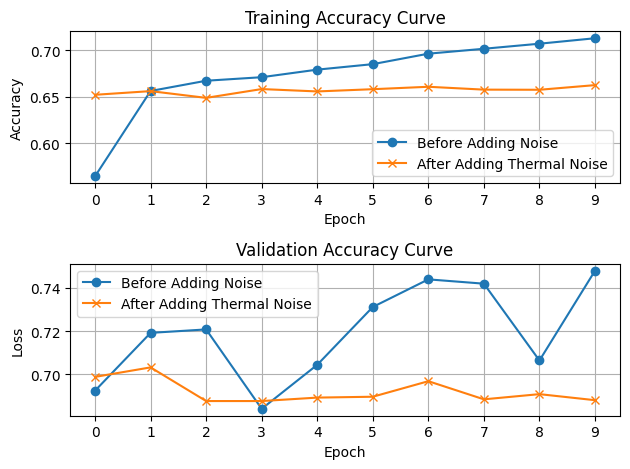

In [117]:
# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_qcnn, marker='o', label='Before Adding Noise')
axs[0].plot(train_accuracy_qcnn_th, marker='x', label='After Adding Thermal Noise')
axs[0].set_title('Training Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(val_accuracy_qcnn, marker='o', label='Before Adding Noise')
axs[1].plot(val_accuracy_qcnn_th, marker='x', label='After Adding Thermal Noise')
axs[1].set_title('Validation Accuracy Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

# QCNN - Wiener Filter

In [119]:
# Fit the data
history_qcnn_thwf = qcnn_model_thwf.fit(x=train_dataset_thwf,
                            epochs=10,
                            validation_data=valid_dataset_thwf,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 18071s 24s/step - loss: 0.6030 - accuracy: 0.6583 - val_loss: 0.5841 - val_accuracy: 0.6764
Epoch 2/10
743/743 [==============================] - 17922s 24s/step - loss: 0.5987 - accuracy: 0.6623 - val_loss: 0.5820 - val_accuracy: 0.6884
Epoch 3/10
743/743 [==============================] - 17954s 24s/step - loss: 0.5982 - accuracy: 0.6614 - val_loss: 0.5669 - val_accuracy: 0.7036
Epoch 4/10
743/743 [==============================] - 17933s 24s/step - loss: 0.6024 - accuracy: 0.6607 - val_loss: 0.5732 - val_accuracy: 0.6916
Epoch 5/10
743/743 [==============================] - 17976s 24s/step - loss: 0.5978 - accuracy: 0.6654 - val_loss: 0.5711 - val_accuracy: 0.6972
Epoch 6/10
743/743 [==============================] - 17942s 24s/step - loss: 0.6007 - accuracy: 0.6621 - val_loss: 0.5724 - val_accuracy: 0.6956
Epoch 7/10
743/743 [==============================] - 17943s 24s/step - loss: 0.6022 - accuracy: 0.6611 - val_loss: 0.5708 -

In [120]:
test_loss_qcnn_thwf, test_acc_qcnn_thwf = qcnn_model_thwf.evaluate(valid_dataset_thwf)
print("Test Accuracy:", test_acc_qcnn_thwf) 

40/40 [==============================] - 494s 12s/step - loss: 0.5863 - accuracy: 0.6896
Test Accuracy: 0.6895999908447266


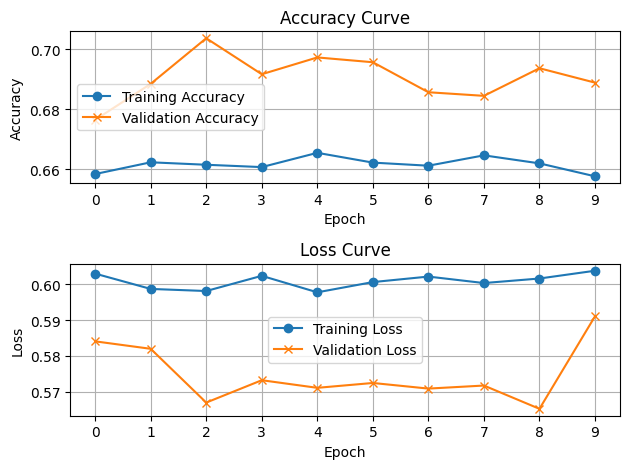

In [121]:
# Define empty lists to store accuracy and loss values
train_loss_qcnn_thwf = []
train_accuracy_qcnn_thwf = []
val_loss_qcnn_thwf = []
val_accuracy_qcnn_thwf = []

# Extract accuracy and loss values from the history object
train_loss_qcnn_thwf = history_qcnn_thwf.history['loss']
train_accuracy_qcnn_thwf = history_qcnn_thwf.history['accuracy']
val_loss_qcnn_thwf = history_qcnn_thwf.history['val_loss']
val_accuracy_qcnn_thwf = history_qcnn_thwf.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_qcnn_thwf, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_qcnn_thwf, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_qcnn_thwf, marker='o', label='Training Loss')
axs[1].plot(val_loss_qcnn_thwf, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [122]:
preds_qcnn_thwf=qcnn_model_thwf.predict(valid_dataset_thwf)
preds_qcnn_thwf

array([[0.37925547],
       [0.39127967],
       [0.38152716],
       ...,
       [0.5078485 ],
       [0.4499761 ],
       [0.41103947]], dtype=float32)

In [123]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_qcnn_thwf = (preds_qcnn_thwf >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_qcnn_thwf = np.concatenate([i.numpy() for _, i in valid_dataset_thwf], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_qcnn_thwf = confusion_matrix(true_labels_qcnn_thwf, binary_predictions_qcnn_thwf)

print("Confusion Matrix:")
print(conf_matrix_qcnn_thwf)

Confusion Matrix:
[[1027  226]
 [ 554  693]]


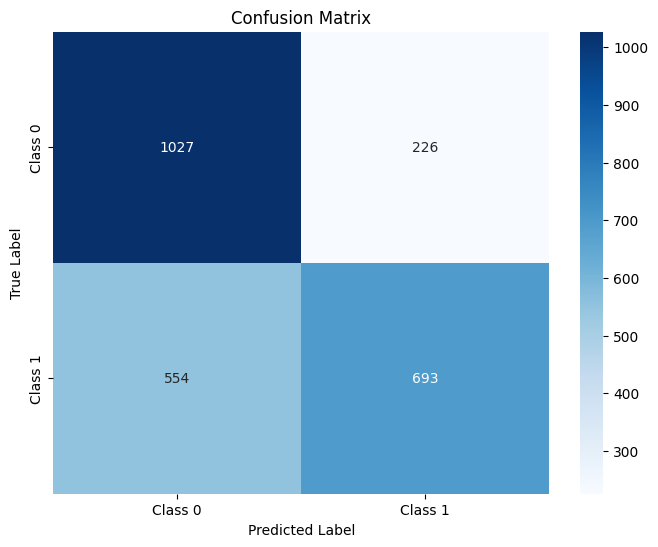

In [124]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qcnn_thwf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

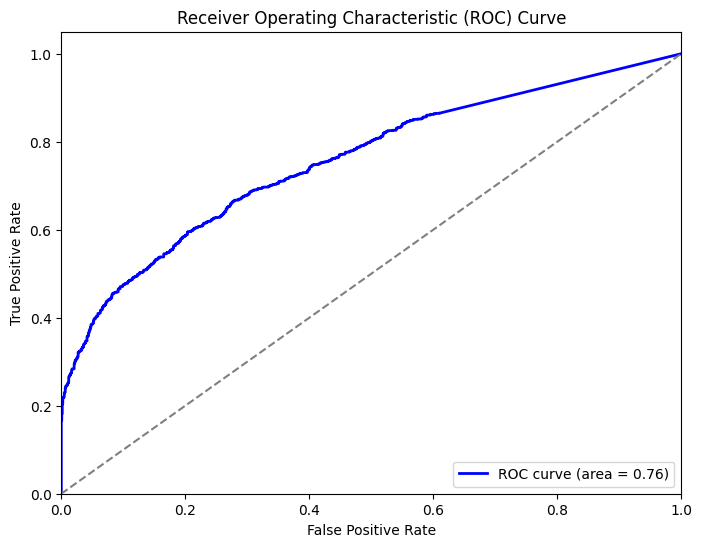

In [125]:
probas_qcnn_thwf = preds_qcnn_thwf.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_qcnn_thwf, tpr_qcnn_thwf, thresholds_qcnn_thwf = roc_curve(true_labels_qcnn_thwf, probas_qcnn_thwf)
roc_auc_qcnn_thwf = auc(fpr_qcnn_thwf, tpr_qcnn_thwf)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_qcnn_thwf, tpr_qcnn_thwf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_qcnn_thwf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# QCNN - Bayesian Inference

In [126]:
# Fit the data
history_qcnn_thbi = qcnn_model_thbi.fit(x=train_dataset_thbi,
                            epochs=10,
                            validation_data=valid_dataset_thbi,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/10
743/743 [==============================] - 17955s 24s/step - loss: 0.6019 - accuracy: 0.6596 - val_loss: 0.5756 - val_accuracy: 0.6900
Epoch 2/10
743/743 [==============================] - 17999s 24s/step - loss: 0.6017 - accuracy: 0.6608 - val_loss: 0.5728 - val_accuracy: 0.6916
Epoch 3/10
743/743 [==============================] - 17918s 24s/step - loss: 0.5998 - accuracy: 0.6645 - val_loss: 0.5670 - val_accuracy: 0.6980
Epoch 4/10
743/743 [==============================] - 17942s 24s/step - loss: 0.5990 - accuracy: 0.6644 - val_loss: 0.5756 - val_accuracy: 0.6844
Epoch 5/10
743/743 [==============================] - 18043s 24s/step - loss: 0.5983 - accuracy: 0.6636 - val_loss: 0.5727 - val_accuracy: 0.6912
Epoch 6/10
743/743 [==============================] - 17939s 24s/step - loss: 0.5988 - accuracy: 0.6621 - val_loss: 0.5797 - val_accuracy: 0.6772
Epoch 7/10
743/743 [==============================] - 18129s 24s/step - loss: 0.5997 - accuracy: 0.6639 - val_loss: 0.5796 -

In [127]:
test_loss_qcnn_thbi, test_acc_qcnn_thbi = qcnn_model_thbi.evaluate(valid_dataset_thbi)
print("Test Accuracy:", test_acc_qcnn_thbi) 

40/40 [==============================] - 811s 20s/step - loss: 0.5736 - accuracy: 0.6876
Test Accuracy: 0.6876000165939331


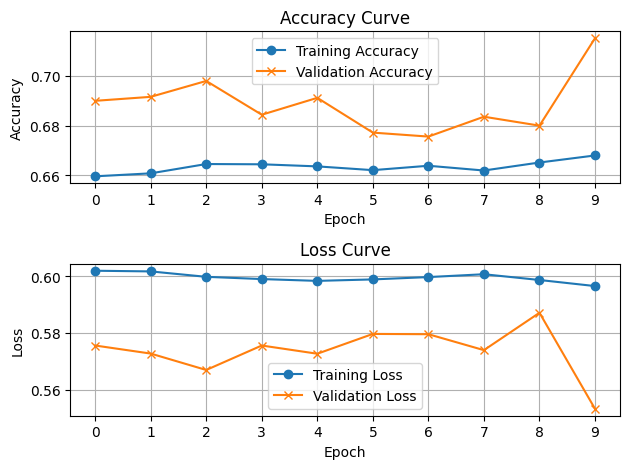

In [128]:
# Define empty lists to store accuracy and loss values
train_loss_qcnn_thbi = []
train_accuracy_qcnn_thbi = []
val_loss_qcnn_thbi = []
val_accuracy_qcnn_thbi = []

# Extract accuracy and loss values from the history object
train_loss_qcnn_thbi = history_qcnn_thbi.history['loss']
train_accuracy_qcnn_thbi = history_qcnn_thbi.history['accuracy']
val_loss_qcnn_thbi = history_qcnn_thbi.history['val_loss']
val_accuracy_qcnn_thbi = history_qcnn_thbi.history['val_accuracy']

# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the accuracy
axs[0].plot(train_accuracy_qcnn_thbi, marker='o', label='Training Accuracy')
axs[0].plot(val_accuracy_qcnn_thbi, marker='x', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the loss
axs[1].plot(train_loss_qcnn_thbi, marker='o', label='Training Loss')
axs[1].plot(val_loss_qcnn_thbi, marker='x', label='Validation Loss')
axs[1].set_title('Loss Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

In [129]:
preds_qcnn_thbi=qcnn_model_thbi.predict(valid_dataset_thbi)
preds_qcnn_thbi

array([[0.37444645],
       [0.41586065],
       [0.37444645],
       ...,
       [0.37444645],
       [0.50903726],
       [0.37444645]], dtype=float32)

In [130]:
# Step 1: Define a threshold
threshold =0.5 # You can adjust this threshold based on your task

# Step 2: Convert probabilities to binary predictions using the threshold
binary_predictions_qcnn_thbi = (preds_qcnn_thbi >= threshold).astype(int)

# Step 3: Extract true labels from the validation dataset
true_labels_qcnn_thbi = np.concatenate([i.numpy() for _, i in valid_dataset_thbi], axis=0)

# Step 4: Compute confusion matrix
conf_matrix_qcnn_thbi = confusion_matrix(true_labels_qcnn_thbi, binary_predictions_qcnn_thbi)

print("Confusion Matrix:")
print(conf_matrix_cnn_thbi)

Confusion Matrix:
[[997 256]
 [511 736]]


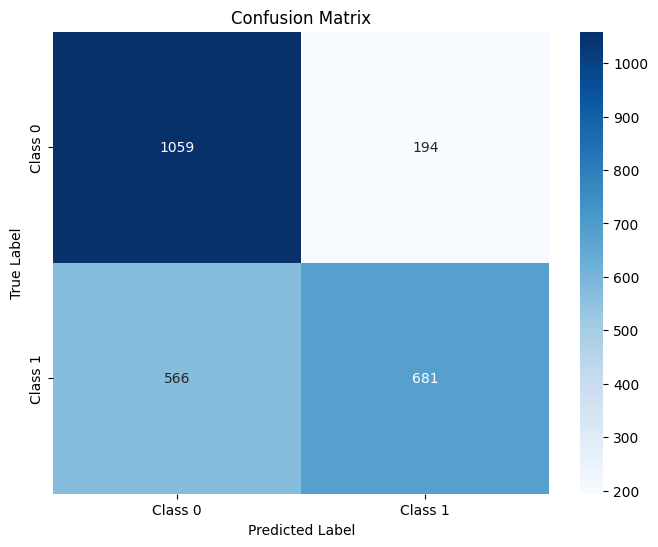

In [131]:
# Define class labels
class_labels = ["Class 0", "Class 1"]

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qcnn_thbi, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

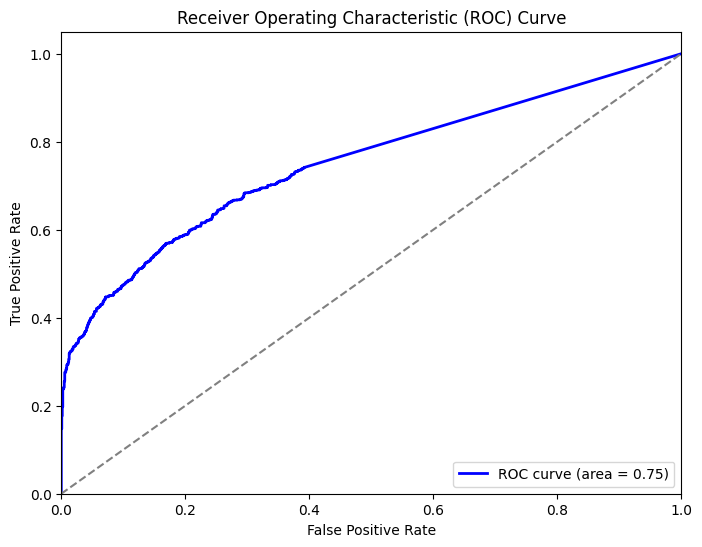

In [132]:
probas_qcnn_thbi = preds_qcnn_thbi.ravel()  # Assuming class 1 is the positive class

# Step 2: Compute ROC curve and AUC
fpr_qcnn_thbi, tpr_qcnn_thbi, thresholds_qcnn_thbi = roc_curve(true_labels_qcnn_thbi, probas_qcnn_thbi)
roc_auc_qcnn_thbi = auc(fpr_qcnn_thbi, tpr_qcnn_thbi)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_qcnn_thbi, tpr_qcnn_thbi, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_qcnn_thbi)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Final QCNN Graph

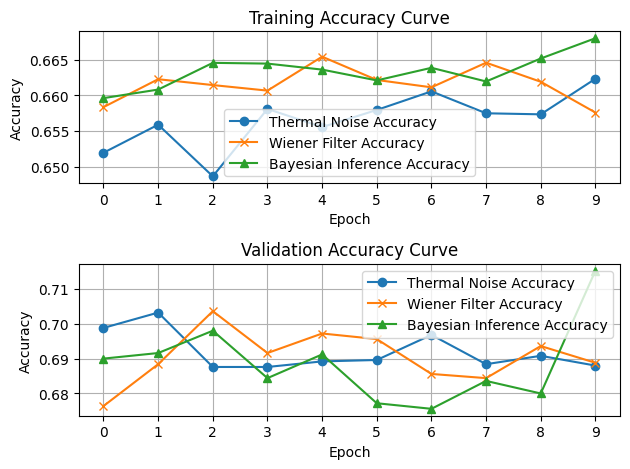

In [133]:
# Create a grid layout for plots
fig, axs = plt.subplots(2, 1)

# Plotting the training accuracy
axs[0].plot(train_accuracy_qcnn_th, marker='o', label='Thermal Noise Accuracy')
axs[0].plot(train_accuracy_qcnn_thwf, marker='x', label='Wiener Filter Accuracy')
axs[0].plot(train_accuracy_qcnn_thbi, marker='^', label='Bayesian Inference Accuracy')
axs[0].set_title('Training Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting the validation accuracy
axs[1].plot(val_accuracy_qcnn_th, marker='o', label='Thermal Noise Accuracy')
axs[1].plot(val_accuracy_qcnn_thwf, marker='x', label='Wiener Filter Accuracy')
axs[1].plot(val_accuracy_qcnn_thbi, marker='^', label='Bayesian Inference Accuracy')
axs[1].set_title('Validation Accuracy Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Display the plots
plt.tight_layout()
plt.show()

# Prediction

In [170]:
test_data0="/home/ubuntu/gwd_data/train/1/6/b/16be39bd33.npy"
test_data1="/home/ubuntu/gwd_data/train/1/6/b/16be77773d.npy"

In [171]:
test_image0=preprocess_function_cqt(tf.convert_to_tensor(test_data0))
test_image0_th=preprocess_function_cqt_th(tf.convert_to_tensor(test_data0))
test_image0_thwf=preprocess_function_cqt_thwf(tf.convert_to_tensor(test_data0))
test_image0_thbi=preprocess_function_cqt_thbi(tf.convert_to_tensor(test_data0))

test_image1=preprocess_function_cqt(tf.convert_to_tensor(test_data1))
test_image1_th=preprocess_function_cqt_th(tf.convert_to_tensor(test_data1))
test_image1_thwf=preprocess_function_cqt_thwf(tf.convert_to_tensor(test_data1))
test_image1_thbi=preprocess_function_cqt_thbi(tf.convert_to_tensor(test_data1))

In [172]:
test_image0_reshaped = np.reshape(test_image0, (1, 28, 96, 1))
test_image0_th_reshaped = np.reshape(test_image0_th, (1, 28, 96, 1))
test_image0_thwf_reshaped = np.reshape(test_image0_thwf, (1, 28, 96, 1))
test_image0_thbi_reshaped = np.reshape(test_image0_thbi, (1, 28, 96, 1))

test_image1_reshaped = np.reshape(test_image1, (1, 28, 96, 1))
test_image1_th_reshaped = np.reshape(test_image1_th, (1, 28, 96, 1))
test_image1_thwf_reshaped = np.reshape(test_image1_thwf, (1, 28, 96, 1))
test_image1_thbi_reshaped = np.reshape(test_image1_thbi, (1, 28, 96, 1))

In [173]:
preds_cnn_test0=model_cnn.predict(test_image0_reshaped)
preds_cnn_th_test0=model_cnn_th.predict(test_image0_th_reshaped)
preds_cnn_thwf_test0=model_cnn_thwf.predict(test_image0_thwf_reshaped)
preds_cnn_thbi_test0=model_cnn_thbi.predict(test_image0_thbi_reshaped)

preds_cnn_test1=model_cnn.predict(test_image1_reshaped)
preds_cnn_th_test1=model_cnn_th.predict(test_image1_th_reshaped)
preds_cnn_thwf_test1=model_cnn_thwf.predict(test_image1_thwf_reshaped)
preds_cnn_thbi_test1=model_cnn_thbi.predict(test_image1_thbi_reshaped)

preds_qcnn_test0=qcnn_model.predict(test_image0_reshaped)
preds_qcnn_th_test0=qcnn_model_th.predict(test_image0_th_reshaped)
preds_qcnn_thwf_test0=qcnn_model_thwf.predict(test_image0_thwf_reshaped)
preds_qcnn_thbi_test0=qcnn_model_thbi.predict(test_image0_thbi_reshaped)

preds_qcnn_test1=qcnn_model.predict(test_image1_reshaped)
preds_qcnn_th_test1=qcnn_model_th.predict(test_image1_th_reshaped)
preds_qcnn_thwf_test1=qcnn_model_thwf.predict(test_image1_thwf_reshaped)
preds_qcnn_thbi_test1=qcnn_model_thbi.predict(test_image1_thbi_reshaped)

In [176]:
print("Gravitation Wave Target = 0")
print("\nCNN Result")
print("Before adding Noise = ",preds_cnn_test0[0][0])
print("After adding Thermal Noise = ",preds_cnn_th_test0[0][0])
print("Removing Noise using Wiener Filter = ",preds_cnn_thwf_test0[0][0])
print("Removing Noise using Bayesian Filter = ", preds_cnn_thwf_test0[0][0])

print("\nQCNN Result")
print("Before adding Noise = ",preds_qcnn_test0[0][0])
print("After adding Thermal Noise = ",preds_qcnn_th_test0[0][0])
print("Removing Noise using Wiener Filter = ",preds_qcnn_thwf_test0[0][0])
print("Removing Noise using Bayesian Filter = ", preds_qcnn_thwf_test0[0][0])

Gravitation Wave Target = 0

CNN Result
Before adding Noise =  0.40568045
After adding Thermal Noise =  0.3953618
Removing Noise using Wiener Filter =  0.41402256
Removing Noise using Bayesian Filter =  0.41402256

QCNN Result
Before adding Noise =  0.37444645
After adding Thermal Noise =  0.37444645
Removing Noise using Wiener Filter =  0.37444645
Removing Noise using Bayesian Filter =  0.37444645


In [177]:
print("Gravitation Wave Target = 1")
print("\nCNN Result")
print("Before adding Noise = ",preds_cnn_test1[0][0])
print("After adding Thermal Noise = ",preds_cnn_th_test1[0][0])
print("Removing Noise using Wiener Filter = ",preds_cnn_thwf_test1[0][0])
print("Removing Noise using Bayesian Filter = ", preds_cnn_thwf_test1[0][0])

print("\nQCNN Result")
print("Before adding Noise = ",preds_qcnn_test1[0][0])
print("After adding Thermal Noise = ",preds_qcnn_th_test1[0][0])
print("Removing Noise using Wiener Filter = ",preds_qcnn_thwf_test1[0][0])
print("Removing Noise using Bayesian Filter = ", preds_qcnn_thwf_test1[0][0])

Gravitation Wave Target = 1

CNN Result
Before adding Noise =  0.7889183
After adding Thermal Noise =  0.61509
Removing Noise using Wiener Filter =  0.8002399
Removing Noise using Bayesian Filter =  0.8002399

QCNN Result
Before adding Noise =  0.913001
After adding Thermal Noise =  0.56456625
Removing Noise using Wiener Filter =  0.8709551
Removing Noise using Bayesian Filter =  0.8709551
